# Time series

The following code will allow us to represent time series of total fishing hours accross all gear types inside Peru's EEZ and close to its border.

In [1]:
# Setup
## Import packages
import ee
import geemap
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import json
from itertools import chain
## Initialize google earth engine 
ee.Initialize()

Read in Google Earth Engine data:

In [2]:
# Read in the data on fishing hours from google earth engine
dataset = ee.ImageCollection('GFW/GFF/V1/fishing_hours')
# Filter by "WLD" to get all global fishing vessel hours rasters in 2016 by Peru's EEZ extend
effort_all_EEZ = dataset.filterMetadata('country', 'equals', 'WLD') \
        # .filterBounds(aoi) \
        #     .map(lambda image: image.clip(aoi))

To do it, we will have to define both areas of interest (AOI). The first one relative to the EEZ of Peru stored `eez_peru/geojson/eez_peru.geojson`. The second AOI is a square area comprizing the EEZ and the neigboring waters in the west.

In [3]:
# Read in EEZ geometry of Peru
with open('eez_peru/geojson/eez_peru.geojson') as f:
  geojson = json.load(f)
coords = geojson["features"][0]["geometry"]["coordinates"]
## The resulting List from the geojson file has an extra bracket that we have to remove to be read it as a polygon
aoi_1 = ee.Geometry.Polygon([i for i in chain.from_iterable(coords)])

In [4]:
# Defining new AOI including areas beyond the EEZ
geojson = {
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {},
      "geometry": {
        "coordinates": [
          [
            [
              -89.8703470212856,
              -2.9010789371311176
            ],
            [
              -89.8703470212856,
              -19.936548732128458
            ],
            [
              -70.081492068508,
              -19.936548732128458
            ],
            [
              -70.081492068508,
              -2.9010789371311176
            ],
            [
              -89.8703470212856,
              -2.9010789371311176
            ]
          ]
        ],
        "type": "Polygon"
      }
    }
  ]
}
coords = geojson["features"][0]["geometry"]["coordinates"]
aoi_2 = ee.Geometry.Polygon(coords)

The dataset exceeds the allowed extraction size form GEE. Therefore, we have to create a function that calls for the data of interest in order to work with it in pandas. The following function allow us to agregate all daily fishing hours values per month. To do so, we get a dataset with monthly data instead of daily. Once we have temporarilly aggregated the data, we apply a `reducer` to sum up all fishing gears in one band and get a unique value representing the total fishing hours.

In [5]:
# Loop ranges:
years = range(2013,2017)
months = range(1,13) # The range counts the steps between monts. The 13 represents the 1st of janueary of the following year.

# Function to extract data of interest:
## .sum() Aggregates collections to single monthly image of global fishing effort
## .reduce(ee.Reducer.sum()) Sum bands to get total effort across all gear types
def monthly_Sum (collection, years, months):
  effort_sum = []
  for year in years:
    for month in months:
      Monthly_sum = collection.filter(ee.Filter.calendarRange(year, year, 'year')) \
                              .filter(ee.Filter.calendarRange(month, month, 'month')) \
                              .sum() \
                              .reduce(ee.Reducer.sum()) \
                              .set('year', year).set('system:time_start', ee.Date.fromYMD(year, 1, 1))\
                              .set('month', month).set('system:time_start', ee.Date.fromYMD(year, month, 1).millis())                                                     
      effort_sum.append (Monthly_sum)
  return ee.ImageCollection.fromImages(effort_sum)

In [7]:
byMonth = monthly_Sum(effort_all_EEZ,years,months)
type(byMonth)

ee.imagecollection.ImageCollection

With it we have now a new image collection with monthly fishing data and all gears combined. Now we must desing a new function that allow us to summarize the data included in our AOIs. The AOI is specified inside the function. Therefore, the following sections will perform time series for each AOI.

### Fishing inside the EEZ

In [8]:
# Function to summarize fishing monthly data:
## Extracting all image values in the collection by the AOI relative to the EEZ
def aoi_sum(img):
    sum = img.reduceRegion(reducer=ee.Reducer.sum(), geometry=aoi_1, 
                           scale=1113.2) # Resolution of the GFW product
    return img.set('time', img.date().millis()).set('sum',sum)

aoi_reduced_imgs = byMonth.map(aoi_sum)
nested_list = aoi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['time','sum']).values().get(0)

In [10]:
# Converting GEE data to Pandas and rearranging it for its representation
df = pd.DataFrame(nested_list.getInfo(), columns=['time','sum'])
df['sum'] = df['sum'].apply(lambda x: x.get('sum'))
df.rename(columns = {'sum':'total_fishing_hours'}, inplace = True)
df["id"] = df.index 
first_column = df.pop('id')
df.insert(0, 'id', first_column)

# Setting time format for representation purposes
df['datetime'] = pd.to_datetime(df['time'], unit='ms')
df['datetime'] = pd.to_datetime(df['datetime'],format="%Y%m%d")
df.head()

,id,time,total_fishing_hours,datetime
0,0,1356998400000,0.000000,2013-01-01
1,1,1359676800000,78.074730,2013-02-01
2,2,1362096000000,150.998493,2013-03-01
3,3,1364774400000,28.296677,2013-04-01
4,4,1367366400000,646.679377,2013-05-01


Text(0, 0.5, 'hours/sq. km')

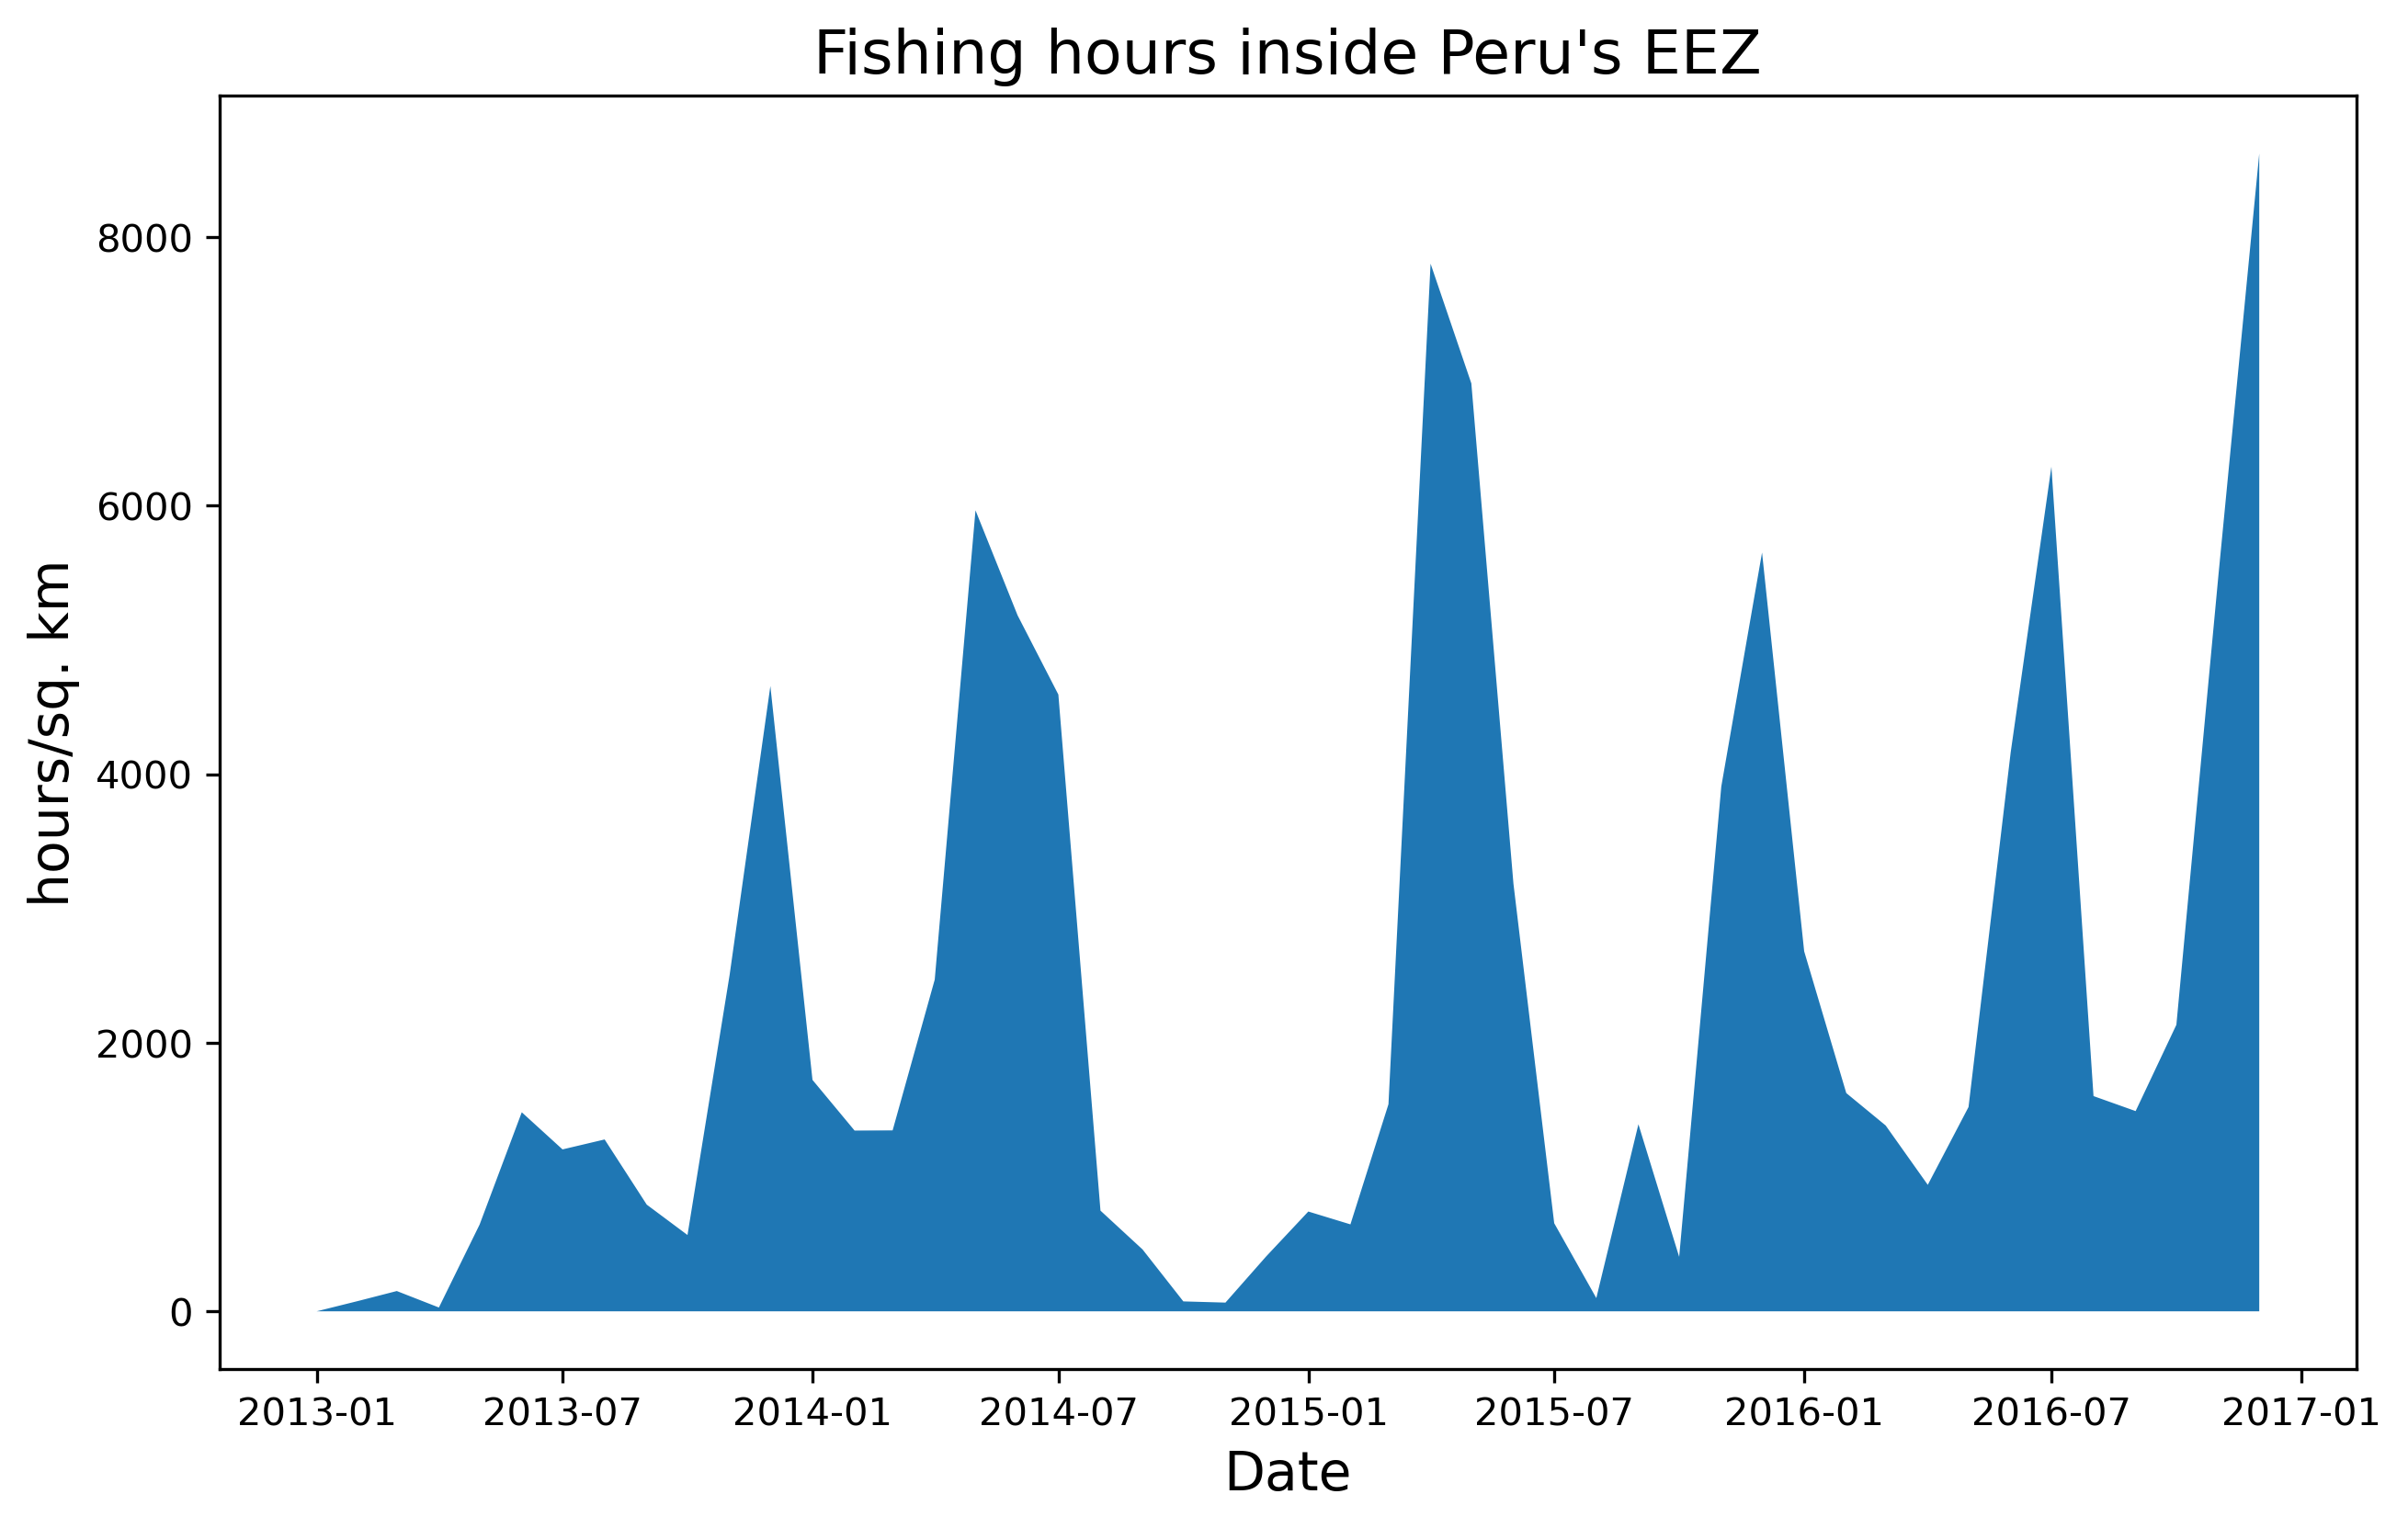

In [14]:
plt.figure(figsize=(10, 6), dpi=300)   # create a new figure, set size and resolution (dpi)
plt.fill_between(df['datetime'],df['total_fishing_hours'])   # add data to the plot
plt.title("Fishing hours inside Peru's EEZ", fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('hours/sq. km', fontsize=14)

### Fishing outside the EEZ

Text(0, 0.5, 'hours/sq. km')

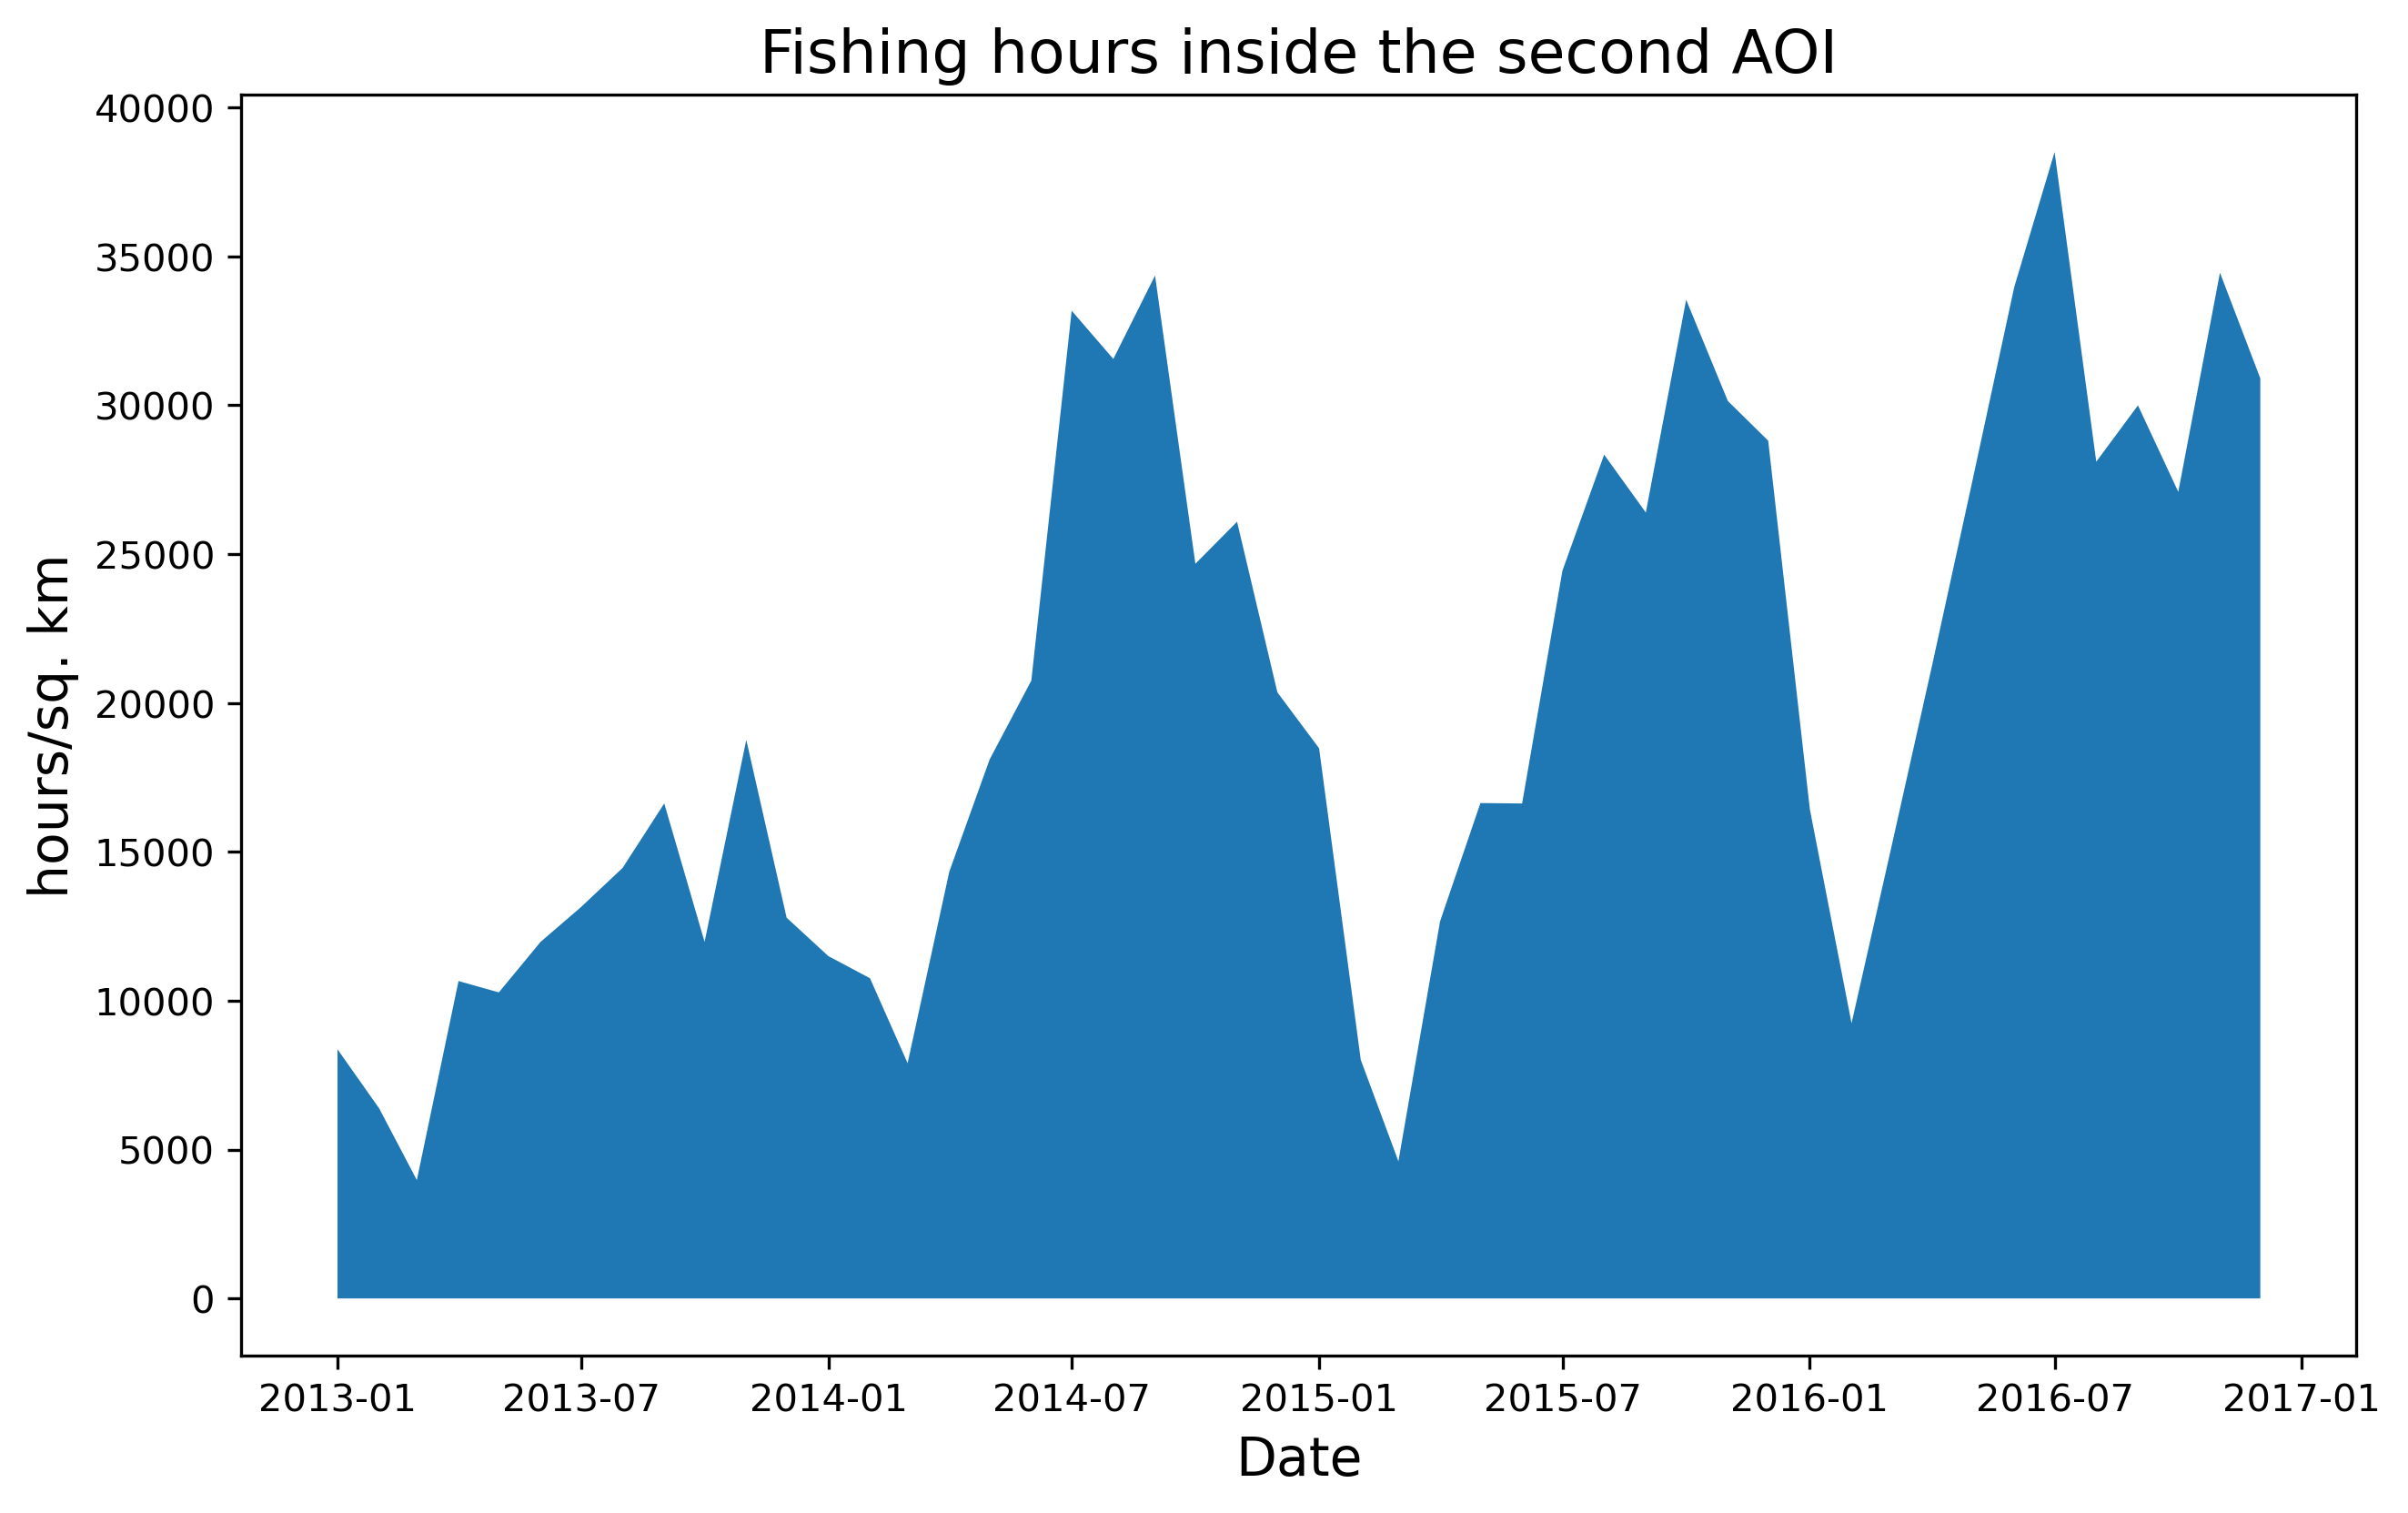

In [34]:
# Function to summarize fishing monthly data inside and outside the EEZ
def aoi_sum(img):
    sum = img.reduceRegion(reducer=ee.Reducer.sum(), geometry=aoi_2, 
                           scale=1113.2)
    return img.set('time', img.date().millis()).set('sum',sum)

aoi_reduced_imgs = byMonth.map(aoi_sum)
nested_list = aoi_reduced_imgs.reduceColumns(ee.Reducer.toList(2), ['time','sum']).values().get(0)

# Converting GEE data to Pandas and rearranging it for its representation
df2 = pd.DataFrame(nested_list.getInfo(), columns=['time','sum'])
df2['sum'] = df2['sum'].apply(lambda x: x.get('sum'))
df2.rename(columns = {'sum':'total_fishing_hours'}, inplace = True)
df2["id"] = df2.index 
first_column = df2.pop('id')
df2.insert(0, 'id', first_column)
df2['datetime'] = pd.to_datetime(df2['time'], unit='ms')
df2['datetime'] = pd.to_datetime(df2['datetime'],format="%Y%m%d")

# Ploting time series
plt.figure(figsize=(10, 6), dpi=300)   
plt.fill_between(df2['datetime'],df2['total_fishing_hours'])
plt.title("Fishing hours inside the second AOI", fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('hours/sq. km', fontsize=14)

### Represent both time series as an area chart

In [29]:
# Combining both df
df["total_fishing_hours_outside"] = abs(df["total_fishing_hours"] - df2["total_fishing_hours"])
df.rename(columns = {'total_fishing_hours':'total_fishing_hours_inside'}, inplace = True)
df.head()

,id,time,total_fishing_hours_inside,datetime,total_fishing_hours_outside
0,0,1356998400000,0.000000,2013-01-01,8367.623958
1,1,1359676800000,78.074730,2013-02-01,6303.453914
2,2,1362096000000,150.998493,2013-03-01,3824.039023
3,3,1364774400000,28.296677,2013-04-01,10632.993636
4,4,1367366400000,646.679377,2013-05-01,9633.352389


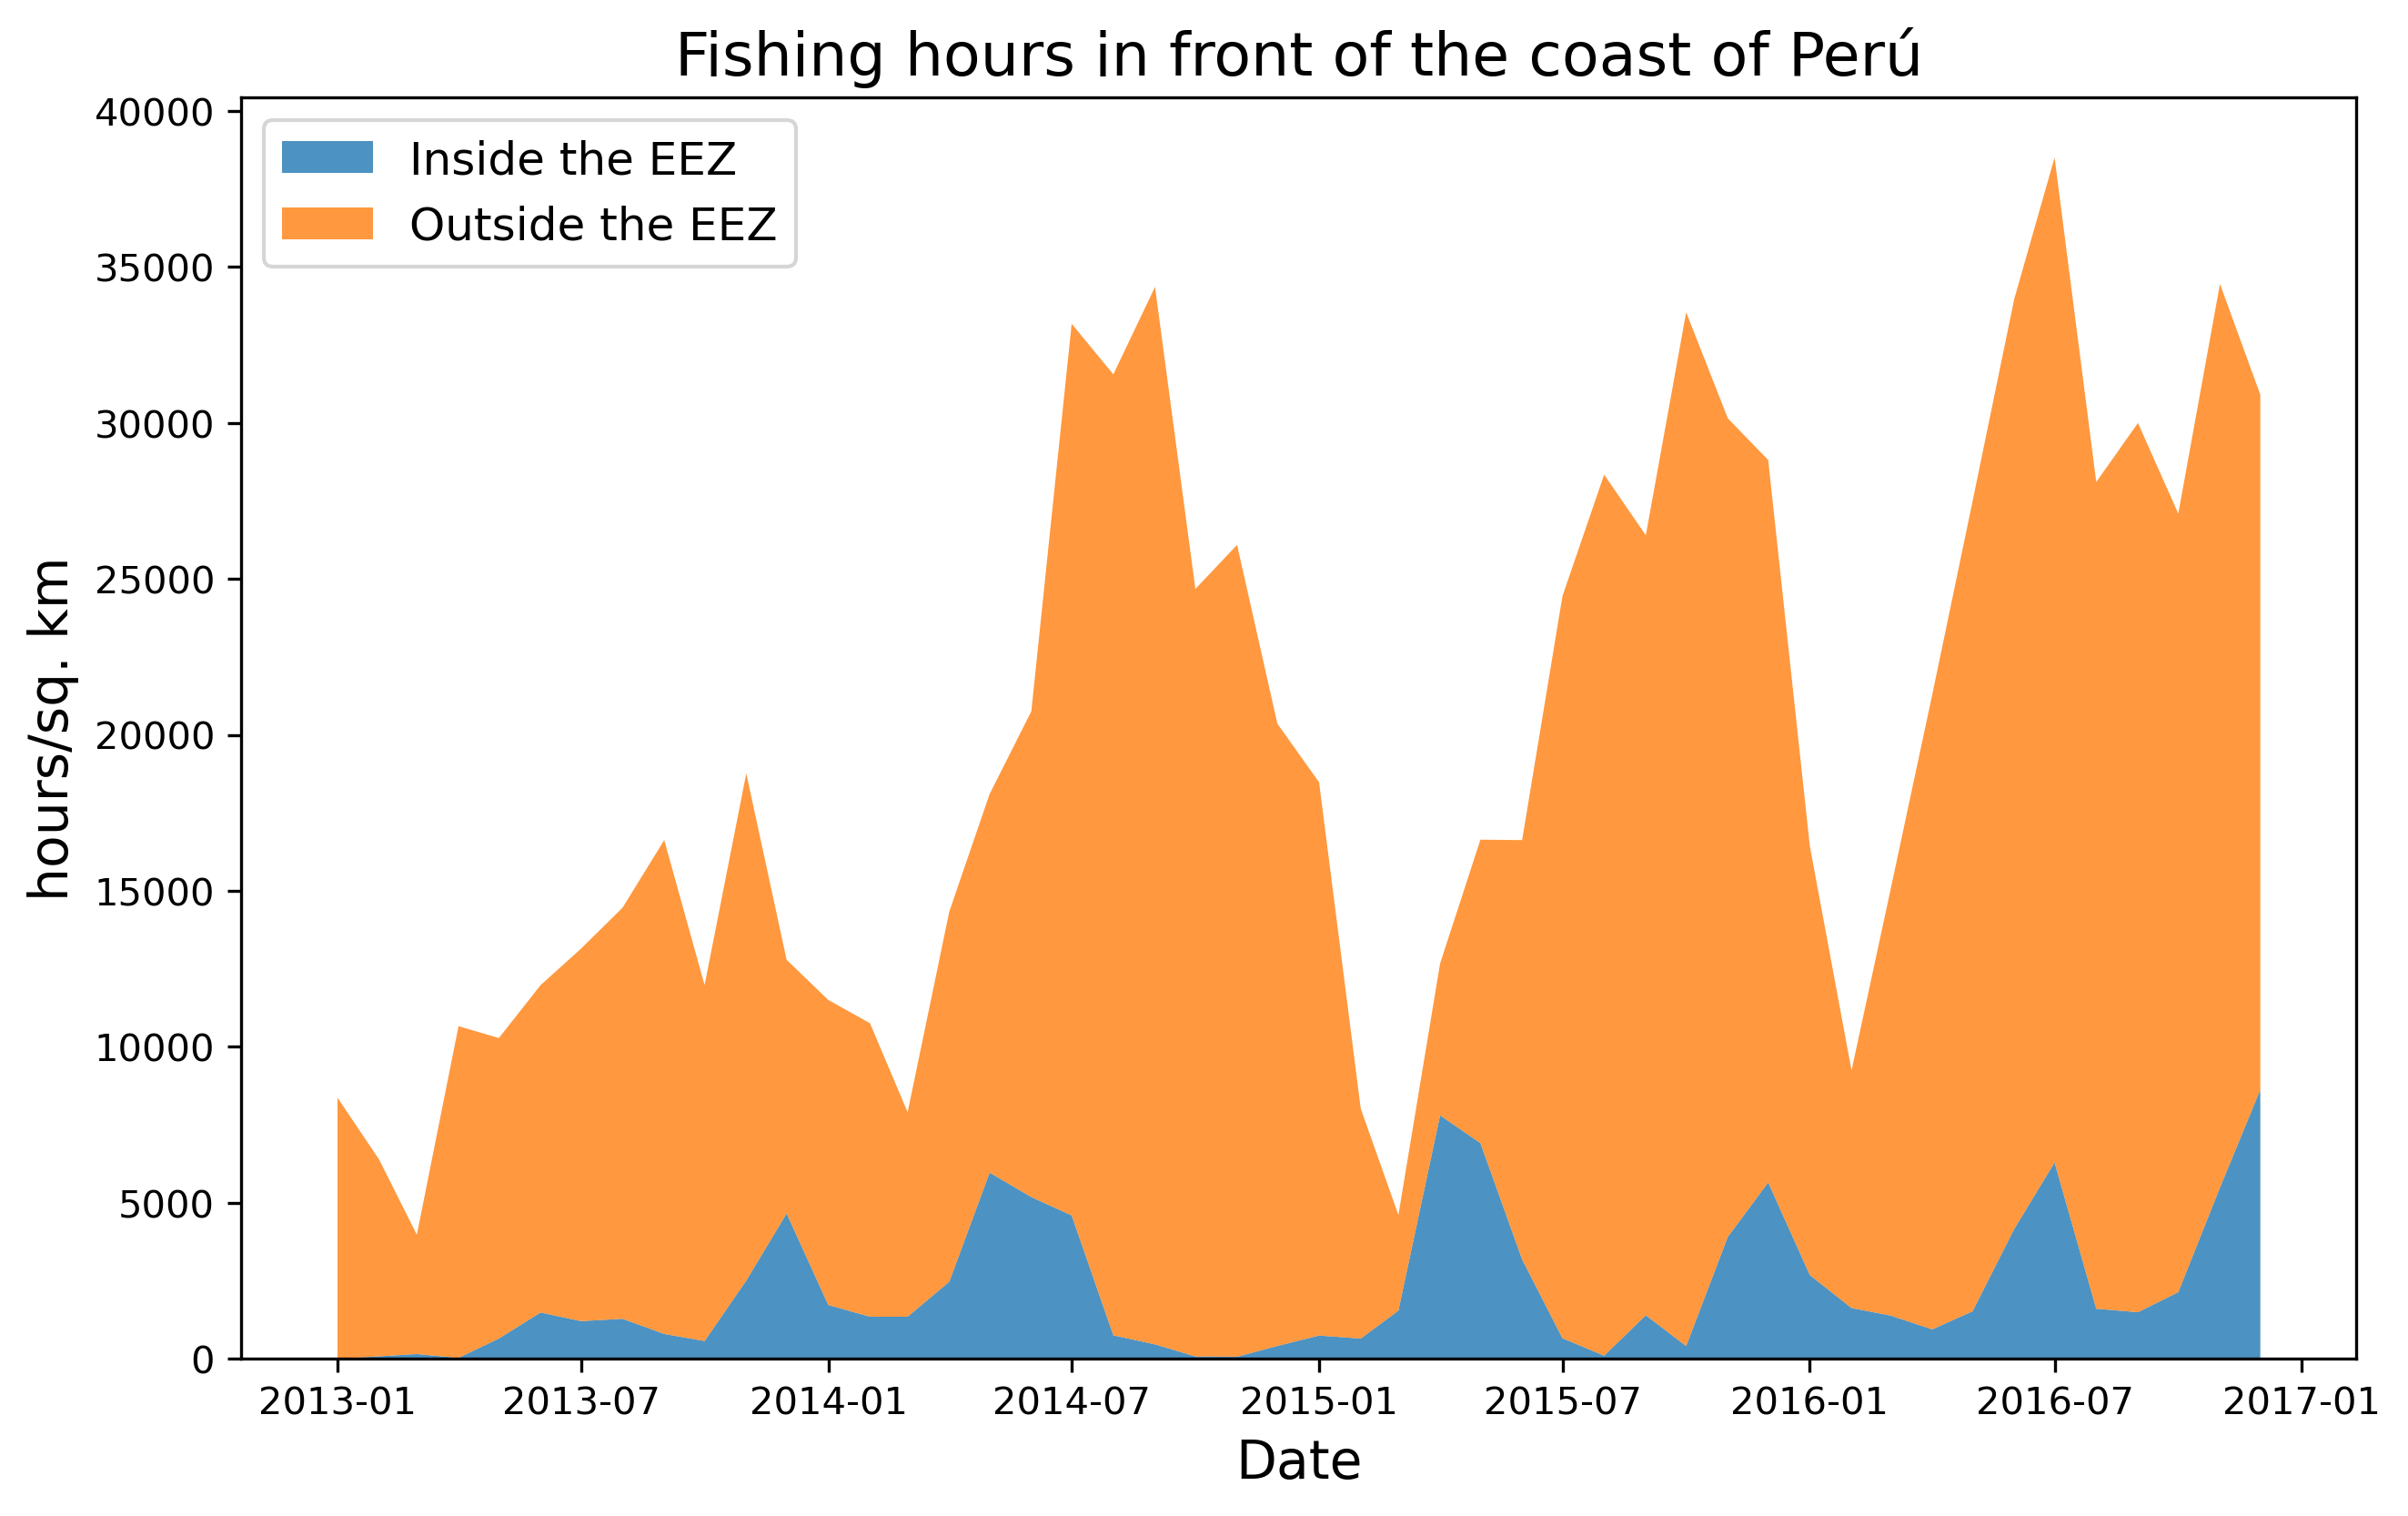

In [32]:
plt.figure(figsize=(10, 6), dpi=300)   
plt.stackplot(df2['datetime'],
              [df['total_fishing_hours_inside'], df['total_fishing_hours_outside']],
              labels=['Inside the EEZ', 'Outside the EEZ'],
              alpha=0.8)
plt.title("Fishing hours in front of the coast of Perú", fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('hours/sq. km', fontsize=14)
plt.legend(loc=2, fontsize='large')
plt.show()